In [1]:
# %pip install pandas networkx numpy os torch torch_geometric node2vec scipy matplotlib

In [10]:
import pandas as pd
import networkx as nx
import numpy as np
import os.path as osp

# import torch
from torch_geometric.datasets import Planetoid
from node2vec import Node2Vec
from torch_geometric.utils import to_dense_adj

from scipy.spatial.distance import pdist
from scipy import linalg
import scipy.sparse.csgraph as csgraph

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering

## Data Import

In [3]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset)  # dowload or load the Cora dataset
data = dataset[0]

Processing...
Done!


In [6]:
# Save the dataset to a .pth file 
# torch.save(dataset, 'd3.pth')

In [7]:
data.node_attrs

<bound method BaseData.node_attrs of Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])>

In [8]:
labels = data.y.tolist()

In [9]:
set(labels)

{0, 1, 2, 3, 4, 5, 6}

# Experiments

In [22]:
def spectral_clustering_on_graph(torch_data, labels, laplacian, number_of_clusters):

    adjacency_matrix = to_dense_adj(torch_data.edge_index).squeeze()
    # Convert the PyTorch tensor to a NumPy array
    adjacency_matrix = adjacency_matrix.numpy()

    dimension = len(adjacency_matrix)

    # Calculate degree matrix
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
    

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
        laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
        laplacian_matrix_normalized = np.matmul(d_inverse, adjacency_matrix)


    # Calculating eigenvalues and eigenvectors
    e, v = np.linalg.eigh(laplacian_matrix_normalized)

    # Eigen features for k
    k = number_of_clusters
    X = v[:, -1*k:]

    # Kmeans
    clustering = KMeans(n_clusters = number_of_clusters)
    clustering.fit(X)
    
    cluster_labels = clustering.labels_
    
    return silhouette_score(adjacency_matrix, cluster_labels, metric = "precomputed"), adjusted_rand_score(labels, cluster_labels)

In [23]:
laplacian_methods = ["sym", "rw"]

silhouette_scores = []
adjusted_rand_scores = []
laplacian = []


for laplace in laplacian_methods:

    laplacian.append(laplace)

    si, ar = spectral_clustering_on_graph(data, labels, laplace, 61)

    silhouette_scores.append(si)
    adjusted_rand_scores.append(ar)

C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [24]:
experiment_cora = pd.DataFrame(list(zip(laplacian,silhouette_scores,adjusted_rand_scores)), 
             columns= ["laplacian", "silhouette", "adjusted_rand"])

experiment_cora

,laplacian,silhouette,adjusted_rand
0,sym,-1.000000,-0.005362
1,rw,-0.973412,-0.009101


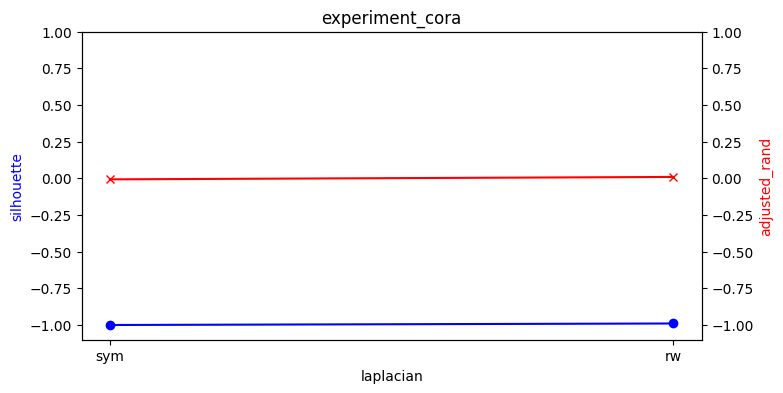

In [36]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot time on the first y-axis
ax.plot(experiment_cora['laplacian'], experiment_cora['silhouette'], marker='o', color='b', label='Time (seconds)')

# Create a second y-axis
ax2 = ax.twinx()

# Plot memory on the second y-axis
ax2.plot(experiment_cora['laplacian'], experiment_cora['adjusted_rand'], marker='x', color='r', label='Memory (KB)')

# Set labels and legends
ax.set_xlabel('laplacian')
ax.set_ylabel('silhouette', color='b')
ax2.set_ylabel('adjusted_rand', color='r')

ax.set_ylim(-1.1, 1)
ax2.set_ylim(-1.1, 1)  # Adjust the multiplier as needed


# Add legends
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')

# Show the plot
plt.title('experiment_cora')
plt.show()

# Breakdown

## Generate Adjacency matrix

In [12]:
adjacency_matrix = to_dense_adj(data.edge_index).squeeze()
# Convert the PyTorch tensor to a NumPy array
adjacency_matrix = adjacency_matrix.numpy()

In [13]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

## Eigen Decomposition

In [15]:
# Calculate degree matrix

dimension = len(adjacency_matrix)

degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

In [16]:
degree_matrix

array([[3., 0., 0., ..., 0., 0., 0.],
       [0., 3., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 4., 0.],
       [0., 0., 0., ..., 0., 0., 4.]])

In [21]:
set(np.diag(degree_matrix))

{1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 21.0,
 22.0,
 23.0,
 26.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 36.0,
 40.0,
 42.0,
 44.0,
 65.0,
 74.0,
 78.0,
 168.0}

In [25]:
# Normalized laplacian matrix
d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
laplacian_matrix = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

# Random walk Laplacian matrix
# d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
# laplacian_matrix = np.matmul(d_inverse, adjacency_matrix)

In [26]:
laplacian_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.25819889, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.25819889, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.25      ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.25      ,
        0.        ]])

In [27]:
# Calculating eigenvalues and eigenvectors
e, v = np.linalg.eigh(laplacian_matrix)

In [19]:
# Eigenvalues
e

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [20]:
# Eigenvectors
v

array([[ 0.00000000e+00,  0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.45347832e-17, -2.51333929e-17, -6.86975536e-17, ...,
        -8.12611802e-18,  1.58679826e-17,  2.69104273e-18],
       [ 9.18449118e-18, -9.50974192e-18,  1.41847777e-17, ...,
         3.55278110e-17, -2.25530472e-17, -6.18393658e-18],
       ...,
       [-2.19416017e-01,  1.23543662e-03, -1.67230457e-01, ...,
         1.01358826e-01, -8.04528638e-02,  1.77770555e-01],
       [ 4.04407410e-17,  1.07336015e-17, -3.11166024e-17, ...,
        -1.04083409e-17,  6.50521303e-18, -8.23993651e-18],
       [ 2.16840434e-18, -1.49077799e-17,  1.82145965e-17, ...,
         4.29344060e-17,  1.08420217e-18, -4.33680869e-18]])

In [ ]:
# Plotting the eigenvalues
plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(range(len(e)), e);
plt.xticks(range(0,len(e)));

In [ ]:
# Gaps in eigenvalues
gaps = np.diff(e)
eigen_gap_df = pd.DataFrame({'Index': range(len(e) - 1), 'Gap': gaps})
eigen_gap_df.sort_values(by='Gap', ascending=False, inplace=True)

In [ ]:
eigen_gap_df

In [ ]:
eigen_gap_df[eigen_gap_df['Index'] < 10]

In [21]:
# Eigen features for k
k = 7
X = v[:, -1*k:]
# Y = X / row_sums[:, np.newaxis]

## Clustering

In [22]:
cluster_df = pd.DataFrame(X)
cluster_df

,0,1,2,3,4,5,6
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,8.543253e-33,-3.178568e-17,-3.948818e-18,-1.239229e-17,-8.126118e-18,1.586798e-17,2.691043e-18
2,-2.747049e-33,-9.846838e-17,-4.004536e-18,2.293163e-17,3.552781e-17,-2.255305e-17,-6.183937e-18
3,5.495624e-33,2.196214e-01,-6.015592e-02,-2.942518e-03,-8.280855e-02,-9.085141e-03,-9.022321e-02
4,-4.663296e-32,-1.369275e-16,4.379059e-17,-2.591236e-17,1.150044e-17,-1.566590e-18,4.736666e-17
...,...,...,...,...,...,...,...
2703,7.694827e-33,0.000000e+00,1.312259e-01,1.466994e-02,-3.196753e-02,-1.009005e-01,8.059722e-02
2704,-9.270165e-34,-7.837769e-02,-7.753428e-02,1.548812e-01,-1.270582e-01,-5.046505e-02,1.152331e-01
2705,1.451173e-32,8.072420e-02,7.270303e-02,-1.170156e-01,1.013588e-01,-8.045286e-02,1.777706e-01
2706,1.954819e-32,9.584347e-17,-3.686287e-17,-7.155734e-18,-1.040834e-17,6.505213e-18,-8.239937e-18


In [28]:
clustering = KMeans(n_clusters = 7)
clustering.fit(cluster_df)

cluster_labels = clustering.labels_
print(silhouette_score(cluster_df, cluster_labels),adjusted_rand_score(labels, cluster_labels))

0.972430808217798 -0.00020896767058245847


C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
clustering = KMeans(n_clusters = 7)
clustering.fit(cluster_df)

C:\Users\mondal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=7)

In [25]:
cluster_labels = clustering.labels_
silhouette_score(adjacency_matrix, cluster_labels, metric = "precomputed")

-0.9966765

In [26]:
adjusted_rand_score(labels, cluster_labels)

-0.001573381507592645